# Use Crocoddyl to run the trajectory

The idea of this page is to take the trajectory given by maciej as an input (cost function) and see if crocoddyl can perform a feasable trajectory.

In [21]:
# import robot_loader from scripts and do basic configuration
import pinocchio as pin
import crocoddyl
import os
import numpy as np
from scripts.robot_loader import *
from scripts.trajectory_utils import convert_trajectory_to_pinocchio_format
import meshcat.geometry as mg

# load model on Meshcat
model, collision_model, visual_model, robot_visualizer, viz = launch_visualization()

print(f"--- Pinocchio model datas ---")
print(f"Robot name: {model.name}")
print(f"Configuration dimension (nq): {model.nq}")
print(f"Velocity dimension (nv): {model.nv}")

# Modify the model to add frames for contact with the ground
model = add_contact_frames(model, contact_z_offset=0.05)
data = model.createData()
robot_visualizer.data = data

# Path to trajectory datas 
trajectory_file = os.path.join("data", "h1v2_squat_fixed_ankle_states.npy")
raw_trajectory = np.load(trajectory_file)

# Display some frames
frames_to_display = ["pelvis", "left_ground_contact", "right_ground_contact"]
frame_ids = [model.getFrameId(frame_name) for frame_name in frames_to_display]
robot_visualizer.displayFrames(True, frame_ids)

# call conversion tool
q_trajectory, v_trajectory = convert_trajectory_to_pinocchio_format(raw_trajectory)

# Display first trajectory data
q0 = q_trajectory[0]
robot_visualizer.display(q0)
pin.forwardKinematics(model, data, q0)
pin.updateFramePlacements(model, data)

--- Searching for robot paths ---
Detected project root directory: /home/cpene/Documents/robot_playground
Asset paths verified.
Detected urdf file: /home/cpene/Documents/robot_playground/robot_models/h1_2_description/h1_2_handless.urdf
Detected mesh directory: /home/cpene/Documents/robot_playground/robot_models/h1_2_description
Launching MeshCat...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7020/static/
Adding a grid to represent the ground.
Loading robot model into Pinocchio...
Pinocchio model loaded successfully.

Environment is ready !
--- Pinocchio model datas ---
Robot name: h1_2
Configuration dimension (nq): 34
Velocity dimension (nv): 33
Frame 'left_ground_contact' added successfully.
Frame 'right_ground_contact' added successfully.
raw trajectory dimension (raw_trajectory.shape): (176, 67)
q trajectory dimension (q_trajectory.shape): (176, 34)
v trajectory dimension (v_trajectory.shape): (176, 33)
Raw trajectory converted and separated into q an

## Implement trajectory with crocoddyl

The aim is to go from configuration x(q, v) to commands u = tau_q

### Step 1: Defining the Robotic System

We need to define the space state **x = (q, v)** and how to perform correct mathematical operations on them (given by pinocchio model).

Then, we need to define the output **u**, that will correspond to the torques of the actuated joints. At this point we need to specify that the robot has a floating base. 

I define an initial guess with gravity compensation. 


### Step 2: Creating the Action Sequence ("Running Models")

This is a loop that runs for each trajectory point from **t=0** to **t=N-1**, with the same time interval provided by the trajectory.

1. convert the trajectory data so it is suitable to be used with pinocchio
2. Create the DAM (Differential Action Model). it contains the dynamics and the costs functions.
3. Define the costs and associated weights :
    - on the state point given by the trajectory (now customized in the yaml file)
    - on the command to minimize the effort
    - on the contact
4. Discretize the model -> Transforms the continuous differential model into a discrete-time action model that the solver can use.
5. Stores the discretized action model for this time interval.     



### Step 3: Creating the Terminal Model

This is for the last point (**t=N**). The steps are the same than for the others points but we change the costs and weights.

Costs :
    - on the state given by the trajectory with high weight



### Step 4: Assembling the Full Problem

Assembles all the pieces into a single optimal control problem.


In [22]:
# Preparing an initial guess
# I will add gravity compensation at a first input for the command
v_zero = np.zeros(model.nv)
a_zero = np.zeros(model.nv)
full_gravity_torques = pin.rnea(model, data, q0, v_zero, a_zero)
actuated_gravity_torques = full_gravity_torques[6:]

print(f"\nDimension of full RNEA vector: {len(full_gravity_torques)}") # should be 33
print(f"Dimension of extracted actuated torques: {len(actuated_gravity_torques)}") # should be 27


Dimension of full RNEA vector: 33
Dimension of extracted actuated torques: 27


In [13]:
# I want to create customisable weight for every element of the trajectory.

import yaml

# I chose to set a manual configuration for weight on a yaml file
config_filepath = 'config/traj_weights.yaml'
with open(config_filepath, 'r') as f:
    config = yaml.safe_load(f)
print(f"Weights configuration loaded : {config['description']}")

traj_weights_list = config['q_weights'] + config['v_weights']

traj_weights = np.array(traj_weights_list) # weights used on the state cost function
assert len(traj_weights) == 66, \
    f"Size error! Your YAML file has {len(traj_weights)} weights, but the state (state.nx) has 66."

activation_weighted = crocoddyl.ActivationModelWeightedQuad(traj_weights**2)

Weights configuration loaded : Fichier de configuration pour le squat.


In [23]:
# --- STEP 1 : Defining the Robotic System ---

state = crocoddyl.StateMultibody(model) # input x = (q, v)
actuation = crocoddyl.ActuationModelFloatingBase(state) # output u = tau_q
print(f"Velocity dimension via the state (state.nv): {state.nv}")
print(f"Dimension expected by Crocoddyl (actuation.nu): {actuation.nu}") # Should be 27

# --- STEP 2 : Creating the Action Sequence ("Running Models") ---
running_models = [] # for each point on the trajectory
dt = 0.03333  # Same as given trajectory

q_trajectory, v_trajectory

for i in range(len(q_trajectory) - 1):

    # get trajectory point
    target_state = np.concatenate([q_trajectory[i+1], v_trajectory[i+1]])

    # 1. Costs
    running_costs = crocoddyl.CostModelSum(state, actuation.nu)
    
    # on the state point given by the trajectory
    residual_state = crocoddyl.ResidualModelState(state, target_state, actuation.nu)
    state_cost = crocoddyl.CostModelResidual(state, activation_weighted, residual_state)
    running_costs.addCost(name="state_cost", cost=state_cost, weight=1e-3)
    
    # on the command to minimize the effort
    residual_control = crocoddyl.ResidualModelControl(state, actuation.nu)
    control_cost = crocoddyl.CostModelResidual(state, residual_control)
    running_costs.addCost(name="control_cost", cost=control_cost, weight=1e-4)

    # on the foots contact
    # Define a cone friction to apply in the feet contact
    mu = 0.7 # value between 0.1 and 1.0. 0.7 is a good value for dry flour and rigid body
    R_cone = np.eye(3) # For a horizontal ground, the identity matrix is what we need.
    friction_cone = crocoddyl.FrictionCone(R_cone, mu) # The Z-axis of this matrix (the 3rd column) corresponds to the normal [0, 0, 1].

    residual_friction_left = crocoddyl.ResidualModelContactFrictionCone(state, left_contact_id, friction_cone, actuation.nu)
    cost_friction_left = crocoddyl.CostModelResidual(state, residual_friction_left)
    running_costs.addCost(name="cost_friction_left", cost=cost_friction_left, weight=1e4)

    residual_friction_right = crocoddyl.ResidualModelContactFrictionCone(state, right_contact_id, friction_cone, actuation.nu)
    cost_friction_right = crocoddyl.CostModelResidual(state, residual_friction_right)
    running_costs.addCost(name="cost_friction_right", cost=cost_friction_right, weight=1e4)
    
    
    # 2. Contacts
    # create the contact container
    contact_model = crocoddyl.ContactModelMultiple(state, actuation.nu)
    # we define 2 contacts, one for each foot
    left_contact_id = model.getFrameId("left_ground_contact")
    left_foot_ref_placement = data.oMf[left_contact_id].copy()
    left_contact = crocoddyl.ContactModel6D(state, left_contact_id, left_foot_ref_placement, pin.LOCAL, actuation.nu)
    contact_model.addContact("left_foot_contact", left_contact)

    right_contact_id = model.getFrameId("right_ground_contact")
    right_foot_ref_placement = data.oMf[right_contact_id].copy()
    right_contact = crocoddyl.ContactModel6D(state, right_contact_id, right_foot_ref_placement, pin.LOCAL, actuation.nu)
    contact_model.addContact("right_foot_contact", right_contact)
    
    # 3. Differential Action Model (DAM)
    # Create a container to store the dynamics and costs
    diff_model = crocoddyl.DifferentialActionModelContactFwdDynamics(state, actuation, contact_model, running_costs)
    # DifferentialActionModelContactFwdDynamics use that for contacts DifferentialActionModelFreeFwdDynamics

    # 4. Create Integrated Action Model (IAM) using EUler. Could use RKR instead
    running_models.append(crocoddyl.IntegratedActionModelRK(diff_model, crocoddyl.RKType(4), dt))
    

# --- STEP 3 : Creating the Action Sequence ("Terminal Model") ---
final_state = np.concatenate([q_trajectory[-1], v_trajectory[-1]])

# 1. Costs
terminal_costs = crocoddyl.CostModelSum(state, actuation.nu)
residual_final_state = crocoddyl.ResidualModelState(state, final_state, actuation.nu)
terminal_state_cost = crocoddyl.CostModelResidual(state, residual_final_state)
terminal_costs.addCost(name="terminal_state_cost", cost=terminal_state_cost, weight=1e2)

# 2. Contacts
terminal_contact_model = crocoddyl.ContactModelMultiple(state, actuation.nu)
terminal_left_contact = crocoddyl.ContactModel6D(state, left_contact_id, pin.SE3.Identity(), pin.LOCAL, actuation.nu)
terminal_contact_model.addContact("left_foot_contact", terminal_left_contact)
terminal_right_contact = crocoddyl.ContactModel6D(state, right_contact_id, pin.SE3.Identity(), pin.LOCAL, actuation.nu)
terminal_contact_model.addContact("right_foot_contact", terminal_right_contact)

# 3. DAM
diff_model = crocoddyl.DifferentialActionModelContactFwdDynamics(state, actuation, terminal_contact_model, terminal_costs)

# 4. IAM
terminal_model = crocoddyl.IntegratedActionModelRK(diff_model, crocoddyl.RKType(4), 0.) # IntegratedActionModelEuler


# --- STEP 4 : Assembling the Full Problem ---
x0 = np.concatenate([q_trajectory[0], v_trajectory[0]])
problem = crocoddyl.ShootingProblem(x0, running_models, terminal_model)

Velocity dimension via the state (state.nv): 33
Dimension expected by Crocoddyl (actuation.nu): 27


In [24]:
# DEBUG print

print(f"\n--- Crocoddyl State Dimensions ---")
print(f"State vector dimension (nx):    {state.nx}")
print(f"Tangent space dimension (ndx): {state.ndx}")
print(f"Control dimension (actuation.nu): {actuation.nu}") # Should be 27

print(f"\n--- Verification ---")
print(f"Is nx = nq + nv?  {state.nx == model.nq + model.nv}")
print(f"Is ndx = nv + nv? {state.ndx == model.nv + model.nv}")


--- Crocoddyl State Dimensions ---
State vector dimension (nx):    67
Tangent space dimension (ndx): 66
Control dimension (actuation.nu): 27

--- Verification ---
Is nx = nq + nv?  True
Is ndx = nv + nv? True


In [25]:
# Create an initial guess 
# we are looking at a problem with 176 states and 175 commands
# xs_init should be of size 176 -> we use the data on the trajectory as the first guess
# us_init should be of size 175 -> use gravity compensation computed earlier
xs_init = []
for i in range(len(q_trajectory)):
    x = np.concatenate([q_trajectory[i], v_trajectory[i]])
    xs_init.append(x)
print(f"xs_init dimension : {len(xs_init)}")

us_init = [actuated_gravity_torques] * 175
print(f"us_init dimension : {len(us_init)}")

print(f"Expected control dimension (nu): {actuation.nu}")
print(f"Provided control dimension: {len(us_init[0])}")
if actuation.nu != len(us_init[0]):
    print("\n/!\\ WARNING: us_init dimension does not match actuation.nu!\n")

xs_init dimension : 176
us_init dimension : 175
Expected control dimension (nu): 27
Provided control dimension: 27


In [26]:
# Create FDDP solver
solver = crocoddyl.SolverFDDP(problem)

solver.setCallbacks([
    crocoddyl.CallbackLogger(),
    #crocoddyl.CallbackVerbose()
])


MAX_ITER = 2000  # max iteration
converged = solver.solve(xs_init, us_init, MAX_ITER)


# 5. Results analysis
if converged:
    print("SUCCESS: FDDP converged.")
else:
    print("FAILURE: FDDP did not converge.")

FAILURE: FDDP did not converge.


In [28]:
# try mim_solver
import mim_solvers
import time
import math

solver = mim_solvers.SolverCSQP(problem)

solver.with_callbacks = True 
solver.termination_tolerance = 1e-3
solver.max_qp_iters = 1000
solver.eps_abs = 1e-5
solver.eps_rel = 0.
solver.use_filter_line_search = True

print("Solving OCP...")
start_time = time.time()
solver.solve(xs_init, us_init)
end_time = time.time()
print(f"Solver finished in {end_time - start_time:.2f} seconds.")


Solving OCP...
Solver finished in 13.63 seconds.


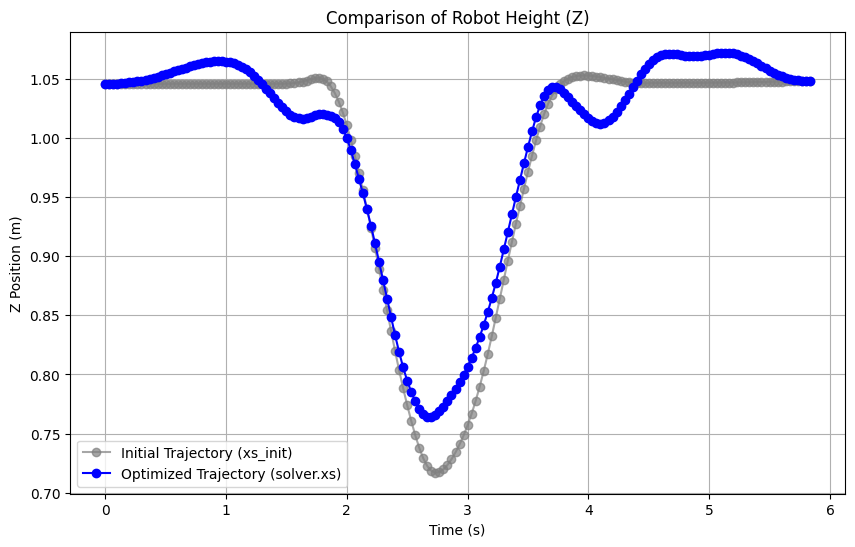

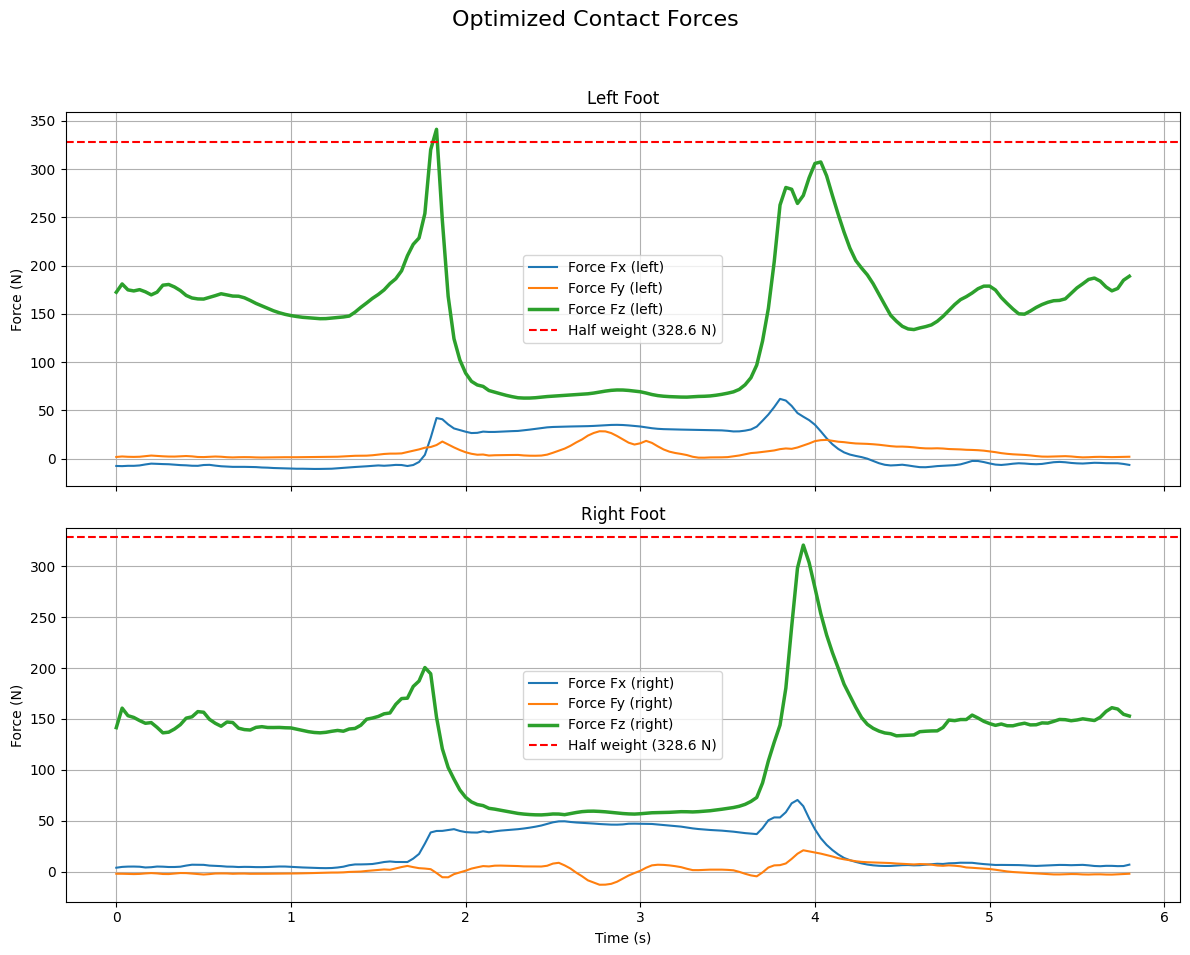

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# output from the solver
xs_res = solver.xs
us_res = solver.us

# Extract a specific coordinate for visualization
# Index 2 corresponds to the Z position of the 'floating base' in Pinocchio (x,y,Z,qx,qy,qz,qw)
# Adapt this index if you want to visualize something else (e.g., a joint angle)
z_initial = [x[2] for x in xs_init]
z_optimized = [x[2] for x in xs_res]

# Create the time axis for the plot
time_axis = np.arange(len(xs_init)) * dt

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_axis, z_initial, 'o-', label="Initial Trajectory (xs_init)", color='gray', alpha=0.7)
plt.plot(time_axis, z_optimized, 'o-', label="Optimized Trajectory (solver.xs)", color='blue')
plt.title("Comparison of Robot Height (Z)")
plt.xlabel("Time (s)")
plt.ylabel("Z Position (m)")
plt.legend()
plt.grid(True)
plt.show()

# --- CONTACT FORCES EXTRACTION ---

# We retrieve data from each time step (except the terminal node)
running_datas = solver.problem.runningDatas

left_forces = []
right_forces = []

for data in running_datas:

    contact_datas = data.differential[0].multibody.contacts
    
    f_left = contact_datas.contacts['left_foot_contact'].f.vector
    f_right = contact_datas.contacts['right_foot_contact'].f.vector
    
    left_forces.append(f_left)
    right_forces.append(f_right)

left_forces = np.array(left_forces)
right_forces = np.array(right_forces)

time_axis_f = np.arange(len(left_forces)) * dt


# --- DISPLAYING FORCES ---

# Creating a figure with two subplots (one for each foot)
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Optimized Contact Forces', fontsize=16)

# Graph for the left foot
axs[0].plot(time_axis_f, left_forces[:, 0], label="Force Fx (left)")
axs[0].plot(time_axis_f, left_forces[:, 1], label="Force Fy (left)")
axs[0].plot(time_axis_f, left_forces[:, 2], label="Force Fz (left)", linewidth=2.5)
axs[0].set_title("Left Foot")
axs[0].set_ylabel("Force (N)")
axs[0].grid(True)

# Graph for the right foot
axs[1].plot(time_axis_f, right_forces[:, 0], label="Force Fx (right)")
axs[1].plot(time_axis_f, right_forces[:, 1], label="Force Fy (right)")
axs[1].plot(time_axis_f, right_forces[:, 2], label="Force Fz (right)", linewidth=2.5)
axs[1].set_title("Right Foot")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Force (N)")
axs[1].grid(True)

# Display total robot weight as a reference
try:
    robot_weight = pin.computeTotalMass(model) * 9.81
    axs[0].axhline(y=robot_weight/2, color='r', linestyle='--', label=f'Half weight ({robot_weight/2:.1f} N)')
    axs[1].axhline(y=robot_weight/2, color='r', linestyle='--', label=f'Half weight ({robot_weight/2:.1f} N)')
except NameError:
    print("Variable 'q0' is not defined, unable to display robot weight.")

axs[0].legend()
axs[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [31]:
# Launch the simulation
import time
print("Starting animation...")
dt = 0.033

xs_opt = solver.xs
xs_opt_array = np.array(solver.xs)
q_trajectory = xs_opt_array[:, :model.nq]

for q in q_trajectory:

    # Send q to robot visualization
    robot_visualizer.display(q)

    # dt is 0.033333333 s
    time.sleep(0.033)

print("\nAnimation end.")

Starting animation...

Animation end.


In [ ]:
# Save output trajectory

from scripts.trajectory_utils import convert_pinocchio_to_trajectory_format

output_filename = 'data/crocoddyl_traj_13082025.npy'


v_trajectory = xs_opt_array[:, model.nq:]

x_opt_trajectory = convert_pinocchio_to_trajectory_format(q_trajectory, v_trajectory)

print(f"\nSaving the trajectory to '{output_filename}'...")
np.save(output_filename, x_opt_trajectory)

print(f"Trajectory successfully saved. Shape: {x_opt_trajectory.shape}")